# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

In [63]:
#Helper functions

import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    left_line_x = []
    left_line_y = []
    right_line_x = []
    right_line_y = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            if (y2 - y1)/(x2 - x1) > 0:
                right_line_x.extend([x1, x2])
                right_line_y.extend([y1, y2])
            elif (y2 - y1)/(x2 - x1) < 0:
                left_line_x.extend([x1, x2])
                left_line_y.extend([y1, y2])
    #cv2.line(img, (min(left_line_x), max(left_line_y)), (max(left_line_x), min(left_line_y)), color, thickness)
    #cv2.line(img, (max(right_line_x), max(right_line_y)), (min(right_line_x), min(right_line_y)), color, thickness)
    if len(left_line_x) > 1:
        left_m, left_c = linear_fit(left_line_x, left_line_y)
        draw_a_line(left_m, left_c, img, color, thickness)
    if len(right_line_x) > 1:
        right_m, right_c = linear_fit(right_line_x, right_line_y)
        draw_a_line(right_m, right_c, img, color, thickness)

def linear_regression(x, y):
    A = np.vstack([x, np.ones(len(x))]).T
    return np.linalg.lstsq(A, y)[0]

def linear_fit(x, y):
    fit = np.polyfit(x, y, 1)
    return (fit[0], fit[1])

def draw_a_line(m, c, img, color, thickness):
    if m == 0:
        return
    lower_x = (img.shape[0] - c) / m
    top_x = (0 - c) / m
    if top_x >= 0 and top_x <= img.shape[1]:
        cv2.line(img, (int(lower_x), img.shape[0]), (int(top_x), 0), color, thickness)
    elif top_x < 0:
        top_y = m * 0 + c
        cv2.line(img, (int(lower_x), img.shape[0]), (0, int(top_y)), color, thickness)
    else:
        top_y = m * img.shape[1] + c
        cv2.line(img, (int(lower_x), img.shape[0]), (img.shape[1], int(top_y)), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Image pipeline

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


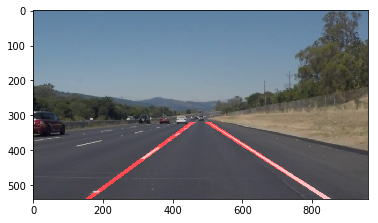

In [64]:
def process_image(image):
    """
    Returns:
     A color image (3 channel) with lines drawn on it for processing video below
    """
    gray = grayscale(image)

    blur_gray = gaussian_blur(gray, 5)

    # Find edges using Canny.
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)

    # Define a four sided polygon to mask
    imshape = image.shape
    vertices = np.array([[(30,imshape[0]),(imshape[1]/2-80, imshape[0]/2+50),(imshape[1]/2+80, imshape[0]/2+50), (imshape[1]-30,imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)

    # Define the Hough transform parameters
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 50     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 10 #minimum number of pixels making up a line
    max_line_gap = 10    # maximum gap in pixels between connectable line segments
    line_img = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    masked_line_img = region_of_interest(line_img, vertices)
    # Overlay with original image
    return weighted_img(masked_line_img, image)


#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
processed_img = process_image(image)
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(processed_img)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Video Pipeline

In [5]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [65]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4












  0%|          | 0/222 [00:00<?, ?it/s]









  1%|          | 2/222 [00:00<00:14, 15.07it/s]









  2%|▏         | 4/222 [00:00<00:15, 14.40it/s]









  3%|▎         | 7/222 [00:00<00:12, 16.67it/s]









  4%|▍         | 9/222 [00:00<00:12, 17.02it/s]









  5%|▌         | 12/222 [00:00<00:11, 18.56it/s]









  7%|▋         | 15/222 [00:00<00:10, 20.38it/s]









  8%|▊         | 18/222 [00:00<00:09, 21.87it/s]









  9%|▉         | 21/222 [00:00<00:08, 22.92it/s]









 11%|█▏        | 25/222 [00:01<00:07, 25.23it/s]









 13%|█▎        | 29/222 [00:01<00:07, 27.55it/s]









 15%|█▍        | 33/222 [00:01<00:06, 28.29it/s]









 17%|█▋        | 38/222 [00:01<00:05, 32.09it/s]









 20%|█▉        | 44/222 [00:01<00:05, 34.35it/s]









 22%|██▏       | 48/222 [00:01<00:07, 23.13it/s]









 23%|██▎       | 51/222 [00:02<00:08, 21.10it/s]









 24%|██▍       | 54/222 [00:02<00:08, 20.24it/s]









 26%|██▌       | 

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 



In [66]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))